In [19]:
import sys
import sklearn
import matplotlib
import numpy as np

In [20]:
from keras.datasets import mnist

(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [21]:
print('Train data: {}'.format(x_train.shape))
print('Train label: {}'.format(y_train.shape))

Train data: (60000, 28, 28)
Train label: (60000,)


In [22]:
print('Test data: {}'.format(x_test.shape))
print('Test label: {}'.format(y_test.shape))

Test data: (10000, 28, 28)
Test label: (10000,)


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

/Users/yashikachugh/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


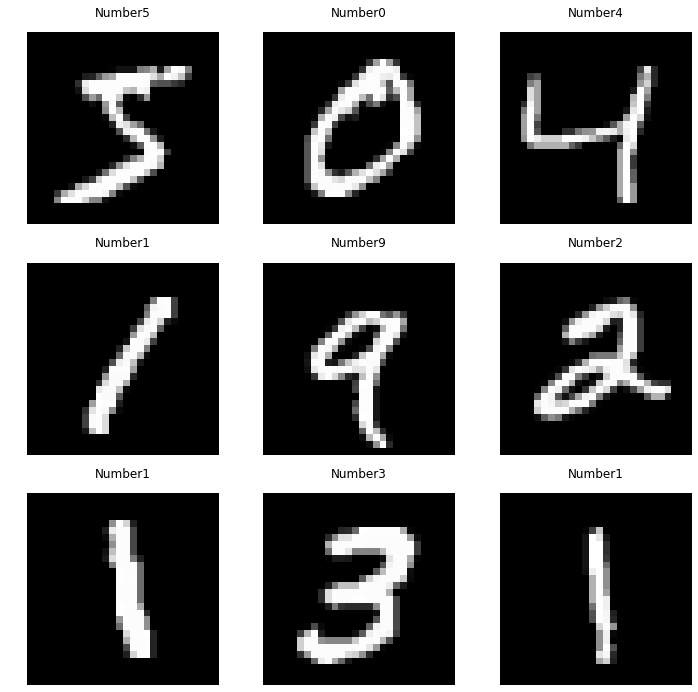

In [24]:
# 3x3 subplots

fig,axs=plt.subplots(3,3, figsize=(12,12))
plt.gray()

for i,ax in enumerate (axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number{}'.format(y_train[i]))
    
fig.show()

In [25]:
#reshape into 1D arrays
X=x_train.reshape(len(x_train),-1)
Y=y_train

In [26]:
X.shape

(60000, 784)

In [27]:
#normalise the data 0-1 (values go up to 255)
X=X.astype(float)/255.0
print(X[0].shape)
print(X[0])


(784,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

In [28]:
from sklearn.cluster import MiniBatchKMeans
n_digits=len(np.unique(y_test))
print(n_digits)

kmeans=MiniBatchKMeans(n_clusters=n_digits)
kmeans.fit(X)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [29]:
kmeans.labels_.shape

(60000,)

In [30]:
def infer_cluster_label(kmeans,actual_labels):
    #Associate most probable label with each cluster and return dictionary assigned to label
    inferred_labels={}
    for i in range (kmeans.n_clusters):
        #find index of points in cluster
        labels=[]
        index=np.where(kmeans.labels_==i)
        
        #append actual labels for each point in cluster
        labels.append(actual_labels[index])
        
        #determine most common label
        if len(labels[0])==1:
            counts=np.bincount(labels[0])
        else:
            counts=np.bincount(np.squeeze(labels))
                
        #assign cluster to a value in inferred_labels dict
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)]=[i]
        
    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    predicted_labels=np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate (X_labels):
        for key,value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i]=key
    
    return predicted_labels

In [31]:
#testing the functions

cluster_labels=infer_cluster_label(kmeans, Y)
X_clusters= kmeans.predict(X)
predicted_labels=infer_data_labels(X_clusters,cluster_labels)
print (predicted_labels[:20])
print (Y[:20])

[8 0 4 2 4 2 1 8 1 2 3 2 3 6 1 7 2 2 6 1]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [32]:
#Optimising and evaluating the clustering algorithm

from sklearn import metrics

def calculate_metrics(estimator,data,labels):
    #calculate and print metrics
    
    print('Number of Clusters{}'.format(estimator.n_clusters))
    print('Intertia{}'.format(estimator.inertia_))
    print('Homogeneity{}'.format(metrics.homogeneity_score(labels,estimator.labels_)))

In [33]:
clusters=[10,16,36,64,144,256]

#test different numbers of clusters 
for n_clusters in clusters:
    estimator=MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X)
    
    calculate_metrics(estimator,X,Y)
    
    #determine predicted labels
    cluster_labels=infer_cluster_label(estimator,Y)
    predicted_Y=infer_data_labels(estimator.labels_,cluster_labels)
    
    print('Accuracy:\n {}'.format(metrics.accuracy_score(Y,predicted_Y)))

Number of Clusters10
Intertia2423311.8358800765
Homogeneity0.4256326049392706
Accuracy:
 0.5333666666666667
Number of Clusters16
Intertia2206022.9073410193
Homogeneity0.5646301798703546
Accuracy:
 0.6729166666666667
Number of Clusters36
Intertia1956724.6548698582
Homogeneity0.6774523335706711
Accuracy:
 0.75635
Number of Clusters64
Intertia1985629.6483022738
Homogeneity0.6892169609940825
Accuracy:
 0.7814333333333333
Number of Clusters144
Intertia1631205.9917124044
Homogeneity0.8094839910161743
Accuracy:
 0.8686833333333334
Number of Clusters256
Intertia1512152.7349686064
Homogeneity0.8408392977340545
Accuracy:
 0.89535


In [34]:
#test kmeans algorithm
#convert each image to 1D array
X_test= x_test.reshape(len(x_test),-1)

X_test=X_test.astype(float)/255.

kmeans=MiniBatchKMeans(n_clusters=256)
kmeans.fit(X)
cluster_labels=infer_cluster_label(kmeans,Y)

#predict

test_clusters=kmeans.predict(X_test)
predicted_labels=infer_data_labels(test_clusters,cluster_labels)

print('Testing Accuracy: {}'.format(metrics.accuracy_score(y_test,predicted_labels)))

Testing Accuracy: 0.9052


/Users/yashikachugh/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


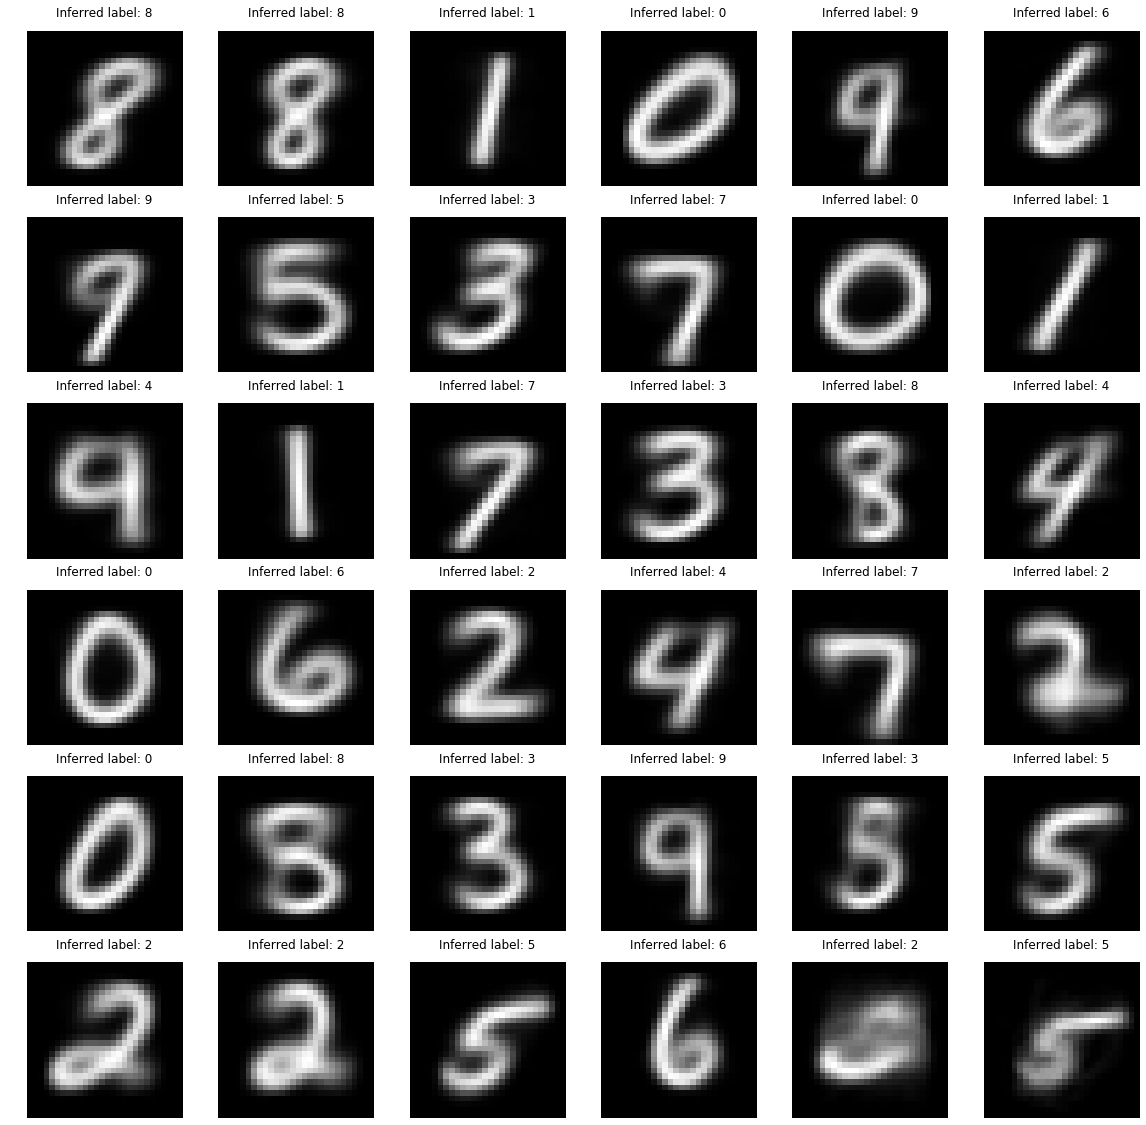

In [36]:
#No overfitting as training and testing accuracy is similar

#visualising clusters

kmeans= MiniBatchKMeans(n_clusters=36)
kmeans.fit(X)

centroids=kmeans.cluster_centers_

#reshape centroids into images
images=centroids.reshape(36,28,28)
images *=255
images=images.astype(np.uint8)

cluster_labels=infer_cluster_label(kmeans,Y)

#create figure

fig,axs= plt.subplots(6,6, figsize=(20,20))

for i,ax in enumerate(axs.flat):
    for key,value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred label: {}'.format(key))
            
    ax.matshow(images[i])
    ax.axis('off')
    
fig.show()